In [2]:
!nvidia-smi

Tue Aug 10 07:09:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [4]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

100% 674M/675M [00:05<00:00, 143MB/s]
100% 675M/675M [00:05<00:00, 126MB/s]


In [5]:
!unzip cell-images-for-detecting-malaria.zip

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_i

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

import random
import shutil

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19

from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.losses import BinaryCrossentropy

In [7]:
data_root = "data"
data_raw = "cell_images"
data_train = os.path.join(data_root, "train")
data_test = os.path.join(data_root, "test")

for folder in os.listdir(data_raw):
  if folder[0] != ".":
    file_list = []
    full_folder = os.path.join(data_raw, folder)
    print(full_folder)
    for file in os.listdir(full_folder):
      if file[0] != ".":
        full_file = os.path.join(full_folder, file)
        file_list.append(full_file)
    
    total_file = len(file_list)
    print("Total: ", total_file)
    len_train = int(total_file*0.8)
    len_test = total_file - len_train
    print(f"len train {len_train} and len test: {len_test}")

    random.shuffle(file_list)
    train_files = file_list[:len_train]
    test_files = file_list[len_train:]
    
    train_folder = os.path.join(data_train, folder)
    if not os.path.exists(train_folder):
      os.makedirs(train_folder)

    for train_file in train_files:
      dest_file = os.path.join(train_folder, os.path.basename(train_file))
      shutil.copyfile(train_file, dest_file)
    
    test_folder = os.path.join(data_test, folder)
    if not os.path.exists(test_folder):
      os.makedirs(test_folder)
    
    for test_file in test_files:
      dest_file = os.path.join(test_folder, os.path.basename(test_file))
      shutil.copyfile(test_file, dest_file)
    

cell_images/Parasitized
Total:  13780
len train 11024 and len test: 2756
cell_images/Uninfected
Total:  13780
len train 11024 and len test: 2756


In [34]:
BATCH_SIZE = 64
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(data_train,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)


Found 22047 files belonging to 2 classes.


In [35]:
validation_dataset = image_dataset_from_directory(data_test,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 5511 files belonging to 2 classes.


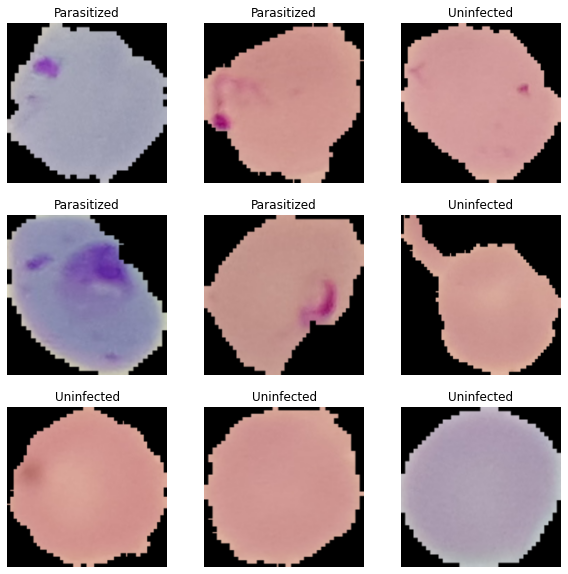

In [36]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [37]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [12]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 70
Number of test batches: 17


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical',
                                                        input_shape=(224, 224, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  # tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])


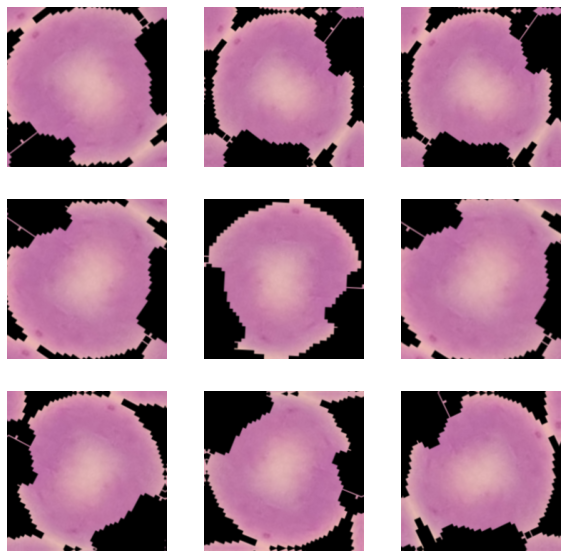

In [15]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [16]:
preprocess_input = preprocess_input

In [17]:
preprocess_input

<function tensorflow.python.keras.applications.vgg19.preprocess_input>

In [18]:
# Create the base model from the pre-trained model VGG19
IMG_SHAPE = IMG_SIZE + (3,)
base_model = VGG19(include_top=False, input_shape=IMG_SHAPE)

80142336/80134624 [==============================] - 1s 0us/step


In [19]:
base_model.trainable = False

In [20]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# x = Flatten()(base_model.output)
# x = 

<KerasTensor: shape=(None, 25088) dtype=float32 (created by layer 'flatten')>

In [21]:
model = Sequential([
    data_augmentation,
    Rescaling(1./255),
    base_model,
    Flatten(),
    Dense(256),
    Dense(128),
    Dense(1)      
])

In [22]:
model.compile(optimizer='adam', loss=BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [24]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/my_projects/MalariaDetection/model/best_weights.hdf5"

checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 verbose=1)


In [25]:
epochs = 50
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=[cp_callback]
)

Epoch 1/50
345/345 [==============================] - 85s 189ms/step - loss: 0.6779 - accuracy: 0.8209 - val_loss: 0.2761 - val_accuracy: 0.8983

Epoch 00001: val_loss improved from inf to 0.27607, saving model to /content/drive/MyDrive/Colab Notebooks/my_projects/MalariaDetection/model/best_weights.hdf5
Epoch 2/50
345/345 [==============================] - 62s 178ms/step - loss: 0.2838 - accuracy: 0.8799 - val_loss: 0.2538 - val_accuracy: 0.9080

Epoch 00002: val_loss improved from 0.27607 to 0.25378, saving model to /content/drive/MyDrive/Colab Notebooks/my_projects/MalariaDetection/model/best_weights.hdf5
Epoch 3/50
345/345 [==============================] - 62s 178ms/step - loss: 0.2776 - accuracy: 0.8851 - val_loss: 0.3219 - val_accuracy: 0.8890

Epoch 00003: val_loss did not improve from 0.25378
Epoch 4/50
345/345 [==============================] - 61s 177ms/step - loss: 0.2459 - accuracy: 0.9013 - val_loss: 0.4011 - val_accuracy: 0.8727

Epoch 00004: val_loss did not improve fro

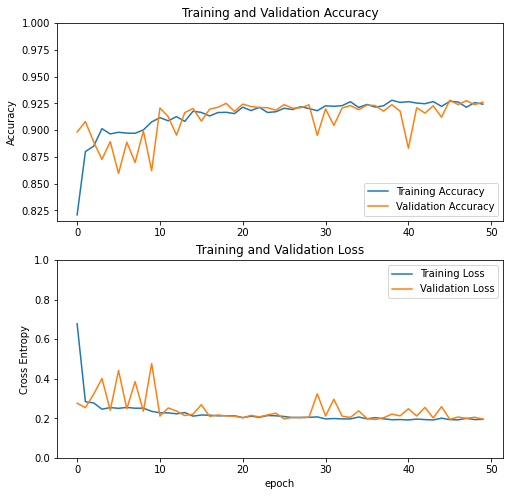

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [27]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

17/17 [==============================] - 3s 138ms/step - loss: 0.1994 - accuracy: 0.9127
Test accuracy : 0.9126838445663452


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0
 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 1 1 0 1 1], shape=(64,), dtype=int32)
tf.Tensor(
[1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0
 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 1 1 0 1 1], shape=(64,), dtype=int32)
tf.Tensor(
[1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0
 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 1 1 0 1 1], shape=(64,), dtype=int32)
tf.Tensor(
[1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0
 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 1 1 0 1 1], shape=(64,), dtype=int32)
tf.Tensor(
[1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0
 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 1 1 0 1 1], shape=(64,), dtype=int32)
tf.Tensor(
[1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0
 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 1 1 0 1 1], shape=(64,),

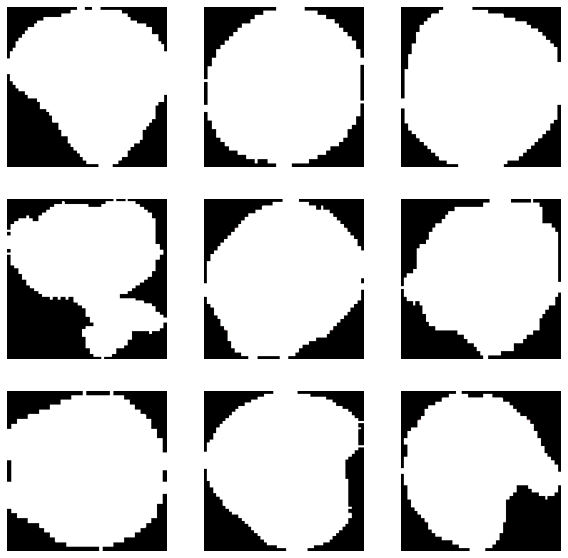

In [33]:
for image, info in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  # first_image = image[0]
  for i in range(9):
    print(info)
    ax = plt.subplot(3, 3, i + 1)
    # augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(image[i])
    plt.axis('off')
